# 데이터 로드

In [244]:
import pandas as pd

In [245]:
travel_path = "../data/VL_csv/tn_travel_여행_E_COST_cleaned.csv"

travel_df = pd.read_csv(travel_path)

## 여행 노드
### 노드 생성 전 전처리 진행
- 비용 범주화 (14만원 -> 10만원, 반올림) (모든 비용 범주화 -> 총액 재계산 필요)
- 특별미션 일반미션 필요없음
- 미션 범주화 진행

#### 예산 값 확인

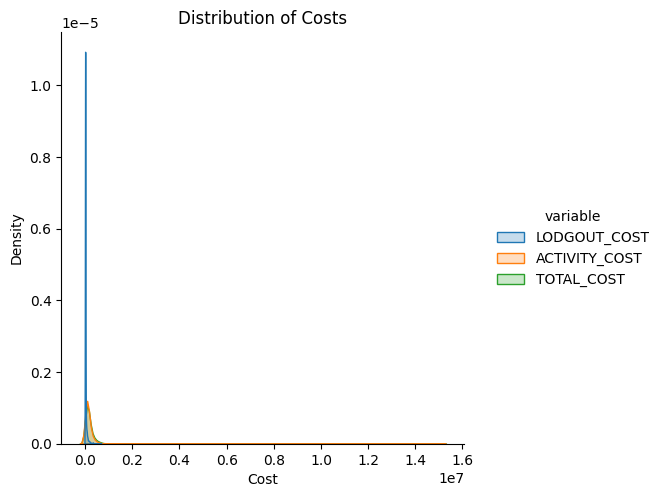

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(travel_df[['LODGOUT_COST', 'ACTIVITY_COST', 'TOTAL_COST']].melt(), x='value', hue='variable', kind='kde', fill=True)
plt.title('Distribution of Costs')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

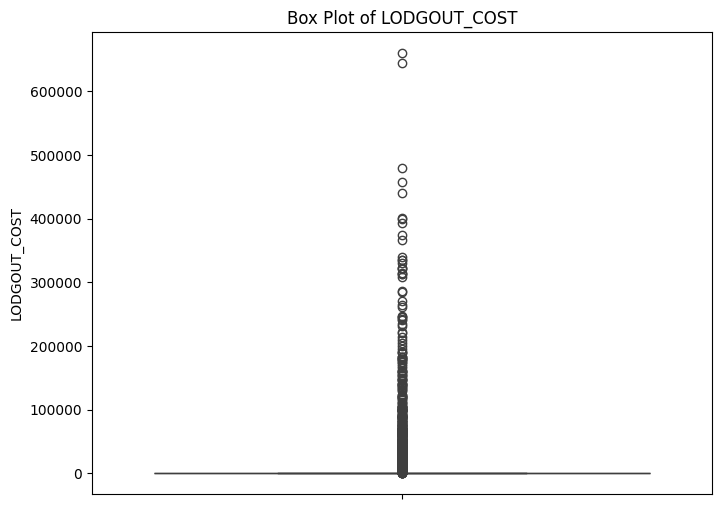

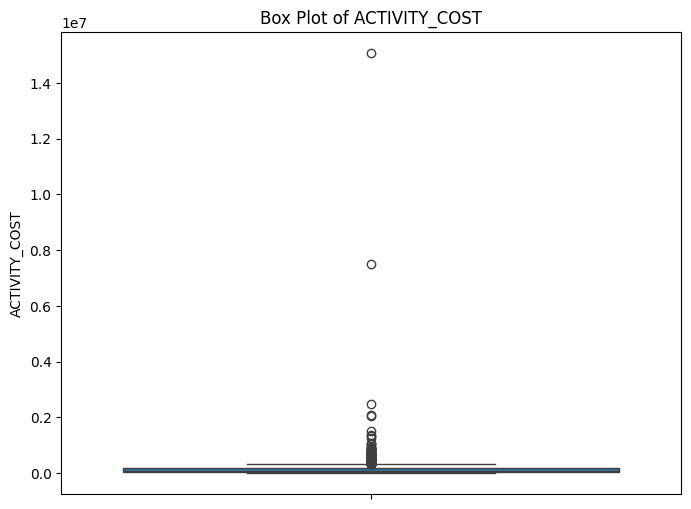

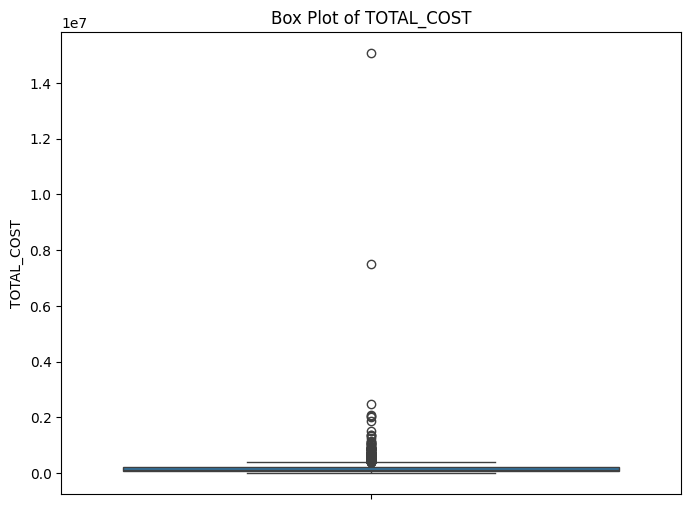

In [247]:
import seaborn as sns

# 박스 플롯 시각화
import matplotlib.pyplot as plt

# 시각화할 변수 선택
columns_to_plot = ['LODGOUT_COST', 'ACTIVITY_COST', 'TOTAL_COST']

# 박스 플롯 생성
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=travel_df, y=column)
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.show()

- 총 예산만 가져가는 것으로 선택
- 실제 소비 내역이 모두 값으로 반영되지 않았음 (정합성 무너진 데이터)

* 총예산 범주화 진행

In [248]:
bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, float('inf')]
labels = ['10만원 이하', '20만원', '30만원', '40만원', '50만원', '60만원', '70만원', '80만원', '90만원', '100만원 이상']

travel_df['TOTAL_COST_BINNED'] = pd.cut(travel_df['TOTAL_COST'], bins=bins, labels=labels, right=False)
travel_df[['TOTAL_COST', 'TOTAL_COST_BINNED']]

,TOTAL_COST,TOTAL_COST_BINNED
0,19000,10만원 이하
1,58500,10만원 이하
2,319340,40만원
3,421160,50만원
4,1044300,100만원 이상
...,...,...
2555,143900,20만원
2556,2000,10만원 이하
2557,22900,10만원 이하
2558,109500,20만원


In [249]:
travel_df.drop(['LODGOUT_COST', 'ACTIVITY_COST', 'TOTAL_COST'], axis=1, inplace=True)

In [250]:
travel_df['TOTAL_COST_BINNED'].value_counts()

TOTAL_COST_BINNED
10만원 이하     1162
20만원         742
30만원         292
40만원         145
50만원          83
60만원          53
70만원          33
100만원 이상      27
80만원          13
90만원          10
Name: count, dtype: int64

In [251]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
travel_df['TOTAL_COST_BINNED_ENCODED'] = label_encoder.fit_transform(travel_df['TOTAL_COST_BINNED'])

travel_df[['TOTAL_COST_BINNED', 'TOTAL_COST_BINNED_ENCODED']].head()

,TOTAL_COST_BINNED,TOTAL_COST_BINNED_ENCODED
0,10만원 이하,1
1,10만원 이하,1
2,40만원,4
3,50만원,5
4,100만원 이상,0


In [252]:
travel_df.drop('TOTAL_COST_BINNED', axis=1, inplace=True)

In [253]:
travel_df.columns

Index(['TRAVEL_ID', 'TRAVEL_NM', 'TRAVELER_ID', 'TRAVEL_PURPOSE',
       'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'MVMN_NM', 'TRAVEL_MISSION',
       'where', 'country', 'age', 'whowith', 'mission',
       'TOTAL_COST_BINNED_ENCODED'],
      dtype='object')

#### 일반여행, 특별여행 제거

In [254]:
travel_df['mission'][:5]

0    일반미션
1    특별미션
2    일반미션
3    일반미션
4    일반미션
Name: mission, dtype: object

In [255]:
travel_df.drop(['mission', 'where', 'age', 'country', 'TRAVEL_MISSION'], axis=1, inplace=True)
travel_df.columns

Index(['TRAVEL_ID', 'TRAVEL_NM', 'TRAVELER_ID', 'TRAVEL_PURPOSE',
       'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'MVMN_NM', 'whowith',
       'TOTAL_COST_BINNED_ENCODED'],
      dtype='object')

#### 미션 매핑

1. 1
2. 3,6,9,12,13
3. 2,11
4. 4,7,23
5. 5, 8, 28
6. 10, 21
7. 22, 26
8. 24
9. 27

##### 반려동물 여부 체크

In [256]:
with_pet = []

for i, row in travel_df.iterrows():
    if '25' in row['TRAVEL_PURPOSE']:
        with_pet.append(1)
    else:
        with_pet.append(0)

In [257]:
travel_df['WITH_PET'] = with_pet

In [258]:
travel_df[['TRAVEL_PURPOSE']]

,TRAVEL_PURPOSE
0,['3']
1,['21']
2,"['2', '4']"
3,"['3', '6']"
4,"['1', '21']"
...,...
2555,"['12', '23', '26', '3', '9']"
2556,"['4', '9']"
2557,['1']
2558,['22']


In [259]:
group_map = {
    1: ['1'],
    2: ['3', '6', '9', '12', '13'],
    3: ['2', '11'],
    4: ['4', '7', '23'],
    5: ['5', '8', '28'],
    6: ['10', '21'],
    7: ['22', '26'],
    8: ['24'],
    9: ['27']
}

code_to_group = {}
for group, codes in group_map.items():
    for code in codes:
        code_to_group[code] = group
code_to_group

{'1': 1,
 '3': 2,
 '6': 2,
 '9': 2,
 '12': 2,
 '13': 2,
 '2': 3,
 '11': 3,
 '4': 4,
 '7': 4,
 '23': 4,
 '5': 5,
 '8': 5,
 '28': 5,
 '10': 6,
 '21': 6,
 '22': 7,
 '26': 7,
 '24': 8,
 '27': 9}

In [260]:
import ast

def map_purpose_group(purpose_str_list):
    try:
        codes = ast.literal_eval(purpose_str_list)  # '["1", "2"]' → ['1', '2']
        group_candidates = [code_to_group[code] for code in codes if code in code_to_group]
        return group_candidates if group_candidates else None
    except:
        return None


In [261]:
travel_df['TRAVEL_PURPOSE_GROUP'] = travel_df['TRAVEL_PURPOSE'].apply(map_purpose_group)
travel_df['TRAVEL_PURPOSE_GROUP']

0                   [2]
1                   [6]
2                [3, 4]
3                [2, 2]
4                [1, 6]
             ...       
2555    [2, 4, 7, 2, 2]
2556             [4, 2]
2557                [1]
2558                [7]
2559    [6, 3, 8, 5, 2]
Name: TRAVEL_PURPOSE_GROUP, Length: 2560, dtype: object

In [262]:
travel_df.drop(['TRAVEL_PURPOSE', 'TRAVEL_NM'], axis = 1, inplace=True)

In [263]:
travel_df['whowith'] = travel_df['whowith'].replace('특별미션', '기타')

In [264]:
travel_df.head().T

,0,1,2,3,4
TRAVEL_ID,e_e000004,e_e000006,e_e000009,e_e000010,e_e000011
TRAVELER_ID,e000004,e000006,e000009,e000010,e000011
TRAVEL_START_YMD,2023-04-30,2023-04-30,2023-04-29,2023-04-29,2023-04-28
TRAVEL_END_YMD,2023-05-01,2023-05-02,2023-05-01,2023-05-01,2023-05-01
MVMN_NM,기타,기타,기타,기타,기타
whowith,자녀동반,기타,커플,나홀로 여행,커플
TOTAL_COST_BINNED_ENCODED,1,1,4,5,0
WITH_PET,0,0,0,0,0
TRAVEL_PURPOSE_GROUP,[2],[6],"[3, 4]","[2, 2]","[1, 6]"


#### 월 피처 추가, 날짜 차이 계산

In [265]:
travel_df['TRAVEL_END_YMD'] = pd.to_datetime(travel_df['TRAVEL_END_YMD'], errors='coerce')
travel_df['TRAVEL_START_YMD'] = pd.to_datetime(travel_df['TRAVEL_START_YMD'], errors='coerce')

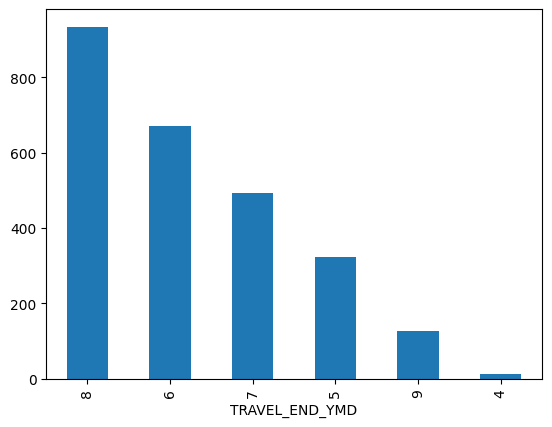

In [266]:
travel_df['TRAVEL_END_YMD'].dt.month.value_counts().plot.bar();

In [267]:
travel_df['MONTH'] = travel_df['TRAVEL_END_YMD'].dt.month

In [268]:
travel_df['DURATION'] = (travel_df['TRAVEL_END_YMD'] - travel_df['TRAVEL_START_YMD']).dt.days

In [269]:
travel_df['DURATION'].value_counts()

DURATION
1    1719
2     664
3     143
4      31
5       3
Name: count, dtype: int64

In [270]:
travel_df.drop(['TRAVEL_START_YMD', 'TRAVEL_END_YMD'], axis=1, inplace=True)

In [271]:
travel_df.head(3).T

,0,1,2
TRAVEL_ID,e_e000004,e_e000006,e_e000009
TRAVELER_ID,e000004,e000006,e000009
MVMN_NM,기타,기타,기타
whowith,자녀동반,기타,커플
TOTAL_COST_BINNED_ENCODED,1,1,4
WITH_PET,0,0,0
TRAVEL_PURPOSE_GROUP,[2],[6],"[3, 4]"
MONTH,5,5,5
DURATION,1,2,2


#### 이동수단 매핑
- 원핫 인코딩으로 진행

In [272]:
travel_df['MVMN_NM'].value_counts()

MVMN_NM
자가용     1222
대중교통    1022
기타       316
Name: count, dtype: int64

In [273]:
travel_df = pd.get_dummies(travel_df, columns=['MVMN_NM'], prefix='MVMN')

#### 여행목적 전처리
- 원핫 인코딩

In [274]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_purpose = mlb.fit_transform(travel_df['TRAVEL_PURPOSE_GROUP'].dropna())

In [275]:
encoded_purpose_df = pd.DataFrame(encoded_purpose, columns=[f'TRAVEL_PURPOSE_{label}' for label in mlb.classes_])
travel_df = pd.concat([travel_df.reset_index(drop=True), encoded_purpose_df.reset_index(drop=True)], axis=1)

In [276]:
travel_df[[f'TRAVEL_PURPOSE_{label}' for label in mlb.classes_]] = travel_df[[f'TRAVEL_PURPOSE_{label}' for label in mlb.classes_]].fillna(0)

In [277]:
travel_df.drop('TRAVEL_PURPOSE_GROUP', axis=1, inplace=True)

In [278]:
print(travel_df.shape)
travel_df.head(3).T

(2560, 19)


,0,1,2
TRAVEL_ID,e_e000004,e_e000006,e_e000009
TRAVELER_ID,e000004,e000006,e000009
whowith,자녀동반,기타,커플
TOTAL_COST_BINNED_ENCODED,1,1,4
WITH_PET,0,0,0
MONTH,5,5,5
DURATION,1,2,2
MVMN_기타,True,True,True
MVMN_대중교통,False,False,False
MVMN_자가용,False,False,False


#### 동반자 컬럼 수정

In [279]:
travel_df['whowith'].value_counts()

whowith
커플          668
기타          663
나홀로 여행      402
자녀동반        361
부부          195
3인 이상 친구    189
부모 동반        49
3대 동반 여행     33
Name: count, dtype: int64

In [280]:
whowith_group_map = {
    '나홀로 여행': '단독여행',
    '커플': '2인여행',
    '부부': '2인여행',
    '3인 이상 친구': '친구/지인 여행',
    '자녀동반': '가족여행',
    '부모 동반': '가족여행',
    '3대 동반 여행': '가족여행',
    '기타': '기타'
}

In [281]:
travel_df['WHOWITH'] = travel_df['whowith'].map(whowith_group_map)
travel_df['WHOWITH'].value_counts()

WHOWITH
2인여행        863
기타          663
가족여행        443
단독여행        402
친구/지인 여행    189
Name: count, dtype: int64

In [282]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
whowith_encoded = encoder.fit_transform(travel_df[['WHOWITH']])

In [283]:
encoded_cols = [f'WHOWITH_{cat}' for cat in encoder.categories_[0]]
whowith_encoded_df = pd.DataFrame(whowith_encoded, columns=encoded_cols, index=travel_df.index)

In [284]:
travel_df = pd.concat([travel_df, whowith_encoded_df], axis=1)

In [285]:
travel_df.drop(['WHOWITH', 'whowith'], axis=1, inplace=True)
travel_df.head(3).T

,0,1,2
TRAVEL_ID,e_e000004,e_e000006,e_e000009
TRAVELER_ID,e000004,e000006,e000009
TOTAL_COST_BINNED_ENCODED,1,1,4
WITH_PET,0,0,0
MONTH,5,5,5
DURATION,1,2,2
MVMN_기타,True,True,True
MVMN_대중교통,False,False,False
MVMN_자가용,False,False,False
TRAVEL_PURPOSE_1,0.0,0.0,0.0


In [286]:
travel_df.to_csv('Processed_Travel.csv')